# Transfer Learning Using PyTorch Lightning ⚡️

## Setting up PyTorch Lightning

For this tutorial, we need PyTorch Lightning

In [1]:
!nvidia-smi

Sun Apr 30 19:50:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:01:00.0 Off |                  Off |
|  0%   56C    P0    68W / 150W |   3195MiB / 24564MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Завершить все процессы, использующие ГПУ в нашей ОС
!fuser -k /dev/nvidia[0]

In [3]:
import os

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torchvision.models as models
from PIL import Image
# your favorite machine learning tracking tool
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms


## The Dataset 💿



In [4]:
class ClassificationDataset(Dataset):
    """
    Датасет с картинками, который производит изменения размера картинок,
    аугментации и преобразование в тензоры PyTorch
    """
    def __init__(self, img_paths, target, mode, rescale_size):
        super().__init__()
        # список файлов для загрузки
        self.files = img_paths
        
        # изменяем размер картинок датасета на указанный
        self.rescale_size = rescale_size
        
        # режим работы
        self.mode = mode
        self.available_modes = ['train', 'val', 'test']

        if self.mode not in self.available_modes:
            print(f"{self.mode} is not correct; correct modes: {self.available_modes}")
            raise NameError

        self.len_ = len(self.files)

        if self.mode != 'test':
            self.target = target
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize(self.rescale_size),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])
        
            # transforms.Normalize делается для того, чтобы подогнать наши 
            # данные под данные на которых были предобучены наши нейронные сети
            # из torchvision.models они были обученные  на наборе данных 
            # ImageNet в документации по самому torchvision.models так же 
            # сказано https://pytorch.org/docs/stable/torchvision/models.html

            # All pre-trained models expect input images normalized in the same way,
            # i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
            # where H and W are expected to be at least 224. The images have to be
            # loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406]
            # and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:
            
            # И ниже код от самих разработчиков PyTorch
            # normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                      std=[0.229, 0.224, 0.225])

        # трансформация с аугментацией для обучающей выборки средствами PyTorch
        transform_augment = transforms.Compose([
            transforms.Resize(size=self.rescale_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(hue=.1, saturation=.1),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        #x = np.array(x / 255, dtype='float32') *см. примечание ниже

        # У нас тр режима датасета 
        # DATA_MODES = ['train', 'val', 'test']
        # train - обучающая выборка на которой мы обучаем нейросеть 
        # (есть картинки и ответы к ним)
        # val - валидационная выборка на которой мы тестируем как хорошо
        #  нейросеть обучилась! (есть картинки и ответы к ним)
        # test - тестовая выборка на которой мы предсказываем ответы для
        #  скора в соревновании (есть картинки ответов нет!)

        if self.mode == 'test': # если тестовая выборка у нас нет ответов и
            x = transform(x)    # датасет не должен аугментировать картинки
            return x
        else:
            if self.mode == 'train': # аугментируем обучающую выборку
                x = transform_augment(x)
            else:
                x = transform(x) # не аугментируем валидационную выборку

            # для train или val выборок у нас есть ответы по классам
            y = self.target[index].item()

            return x, y

In [5]:
class ClassificationDataModule(pl.LightningDataModule):
    def __init__(self, df_train_all, img_path_col, target_col, df_test, val_size, rescale_size, batch_size, num_workers):
        super().__init__()

        # задаем параметры даталоадера
        self.rescale_size = rescale_size
        self.batch_size = batch_size
        self.num_workers = num_workers

        # задаем данные датасета
        train, val = train_test_split(df_train_all,
                                      test_size=val_size,
                                      random_state=42,
                                      stratify=df_train_all[target_col].values)

        train_paths = train[img_path_col].values
        train_target = train[target_col].values
        self.val_paths = val[img_path_col].values
        self.val_target = val[target_col].values
        test_paths = df_test[img_path_col].values

        self.train = ClassificationDataset(train_paths,
                                       train_target,
                                       mode='train',
                                       rescale_size=self.rescale_size)

        self.val = ClassificationDataset(self.val_paths,
                                     self.val_target,
                                     mode='val',
                                     rescale_size=self.rescale_size)

        self.test = ClassificationDataset(test_paths,
                                      None,
                                      mode='test',
                                      rescale_size=self.rescale_size)

    def prepare_data(self):
        pass

    def train_dataloader(self):
        return DataLoader(self.train,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_by_val_dataloader(self):
        test_val = ClassificationDataset(self.val_paths,
                                     None,
                                     mode='test',
                                     rescale_size=self.rescale_size)

        return DataLoader(test_val,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)


## Загрузка данных

In [6]:
train_all = pd.read_csv('RAVDESS_frames_set/train.csv')
test = pd.read_csv('RAVDESS_frames_set/test.csv')

In [7]:
def df_change_paths(df, path, path_col):
    df[path_col] =  path + '/' + df[path_col]

In [8]:
# меняем пути у train и test
path2datset = 'RAVDESS_frames_set'
df_change_paths(train_all, path2datset, path_col = 'image_path')
df_change_paths(test, path2datset, path_col = 'image_path')

In [9]:
train_all.emotion_class -= 1
test.emotion_class -= 1

In [10]:
train_all

,image_path,emotion_class
0,RAVDESS_frames_set/train/02-01-01-01-01-01-01_...,0
1,RAVDESS_frames_set/train/02-01-01-01-01-01-01_...,0
2,RAVDESS_frames_set/train/02-01-01-01-01-01-01_...,0
3,RAVDESS_frames_set/train/02-01-01-01-01-01-01_...,0
4,RAVDESS_frames_set/train/02-01-01-01-01-01-01_...,0
...,...,...
46066,RAVDESS_frames_set/train/02-02-06-02-02-02-19_...,5
46067,RAVDESS_frames_set/train/02-02-06-02-02-02-19_...,5
46068,RAVDESS_frames_set/train/02-02-06-02-02-02-19_...,5
46069,RAVDESS_frames_set/train/02-02-06-02-02-02-19_...,5


In [11]:
test

,image_path,emotion_class
0,RAVDESS_frames_set/test/02-01-01-01-01-01-20_f...,0
1,RAVDESS_frames_set/test/02-01-01-01-01-01-20_f...,0
2,RAVDESS_frames_set/test/02-01-01-01-01-01-20_f...,0
3,RAVDESS_frames_set/test/02-01-01-01-01-01-20_f...,0
4,RAVDESS_frames_set/test/02-01-01-01-01-01-20_f...,0
...,...,...
12900,RAVDESS_frames_set/test/02-02-06-02-02-02-24_f...,5
12901,RAVDESS_frames_set/test/02-02-06-02-02-02-24_f...,5
12902,RAVDESS_frames_set/test/02-02-06-02-02-02-24_f...,5
12903,RAVDESS_frames_set/test/02-02-06-02-02-02-24_f...,5


In [12]:
# число различных эмоций в датасете
emotion_num = len(train_all.emotion_class.unique())
emotion_num

8

## LightingModule - Define the System

Let us look at the model definition to see how transfer learning can be used with PyTorch Lightning.
In the `LitModel` class, we can use the pre-trained model provided by Torchvision as a feature extractor for our classification model. Here we are using ResNet-18. A list of pre-trained models provided by PyTorch Lightning can be found here.
- When `pretrained=True`, we use the pre-trained weights; otherwise, the weights are initialized randomly.
- If `.eval()` is used, then the layers are frozen. 
- A single `Linear` layer is used as the output layer. We can have multiple layers stacked over the `feature_extractor`.

Setting the `transfer` argument to `True` will enable transfer learning.

In [13]:
input = torch.randn(3, 5, requires_grad=True)
input

tensor([[ 0.1380,  0.6685, -0.0073, -1.0130, -0.0760],
        [-1.0171, -1.2225, -0.5208,  1.6187, -1.2939],
        [ 0.5455, -0.1512,  0.6499,  0.4628,  0.1536]], requires_grad=True)

In [14]:
target = torch.randint(5, (3,), dtype=torch.int64)
target

tensor([3, 2, 1])

In [15]:
loss = F.cross_entropy(input, target)
loss

tensor(2.4108, grad_fn=<NllLossBackward0>)

In [16]:
out = torch.tensor([[-0.0321, -1.0382, -0.7115,  0.7244, -0.7180, -0.2087,  0.0209,  0.0369],
        [-0.0024, -0.5507, -0.3870,  0.3491, -0.3878, -0.0760,  0.0271,  0.0739],
        [-0.0069, -0.9884, -0.6649,  0.6924, -0.6594, -0.1798,  0.0361,  0.0328],
        [ 0.0922, -1.1948, -0.7246,  0.7769, -0.7256, -0.1863,  0.0324,  0.0058],
        [-0.0534, -0.2918, -0.2282,  0.1992, -0.2340, -0.0500,  0.0134,  0.0788],
        [ 0.0070, -0.5273, -0.3537,  0.3760, -0.3911, -0.0876,  0.0190,  0.0090],
        [-0.0278, -0.7287, -0.4794,  0.4743, -0.5034, -0.1076,  0.0267,  0.0425],
        [ 0.0318, -1.2083, -0.7701,  0.8049, -0.7718, -0.2089,  0.0230, -0.0132],
        [ 0.0558, -1.1303, -0.6720,  0.7225, -0.6775, -0.1675,  0.0325,  0.0153],
        [-0.0657, -0.2824, -0.2243,  0.2136, -0.2409, -0.0474,  0.0126,  0.0745],
        [ 0.0642, -1.0512, -0.6611,  0.7036, -0.6611, -0.1644,  0.0534,  0.0330],
        [ 0.1440, -1.3713, -0.8318,  0.9156, -0.7692, -0.1917,  0.0347, -0.0290],
        [-0.0380, -0.8143, -0.5513,  0.5606, -0.5839, -0.1679,  0.0308,  0.0403],
        [ 0.0055, -1.1752, -0.7871,  0.8346, -0.7540, -0.2137,  0.0396,  0.0598],
        [-0.0323, -0.7066, -0.4911,  0.4632, -0.5065, -0.1124,  0.0352,  0.0799],
        [-0.0554, -0.8554, -0.6004,  0.5979, -0.6116, -0.1651,  0.0388,  0.0546],
        [-0.0385, -0.7008, -0.4919,  0.5020, -0.5277, -0.1252,  0.0274,  0.0439],
        [ 0.0144, -0.9584, -0.6493,  0.6484, -0.6353, -0.1721,  0.0303,  0.0598],
        [-0.0905, -0.6633, -0.4926,  0.4549, -0.5012, -0.1172,  0.0310,  0.0421],
        [-0.0271, -0.6183, -0.4416,  0.3999, -0.4378, -0.1092,  0.0195,  0.0759],
        [-0.0338, -0.8055, -0.5456,  0.5482, -0.5660, -0.1484,  0.0277,  0.0629],
        [-0.0451, -0.6427, -0.4526,  0.4330, -0.4652, -0.0958,  0.0293,  0.0704],
        [-0.0135, -1.0196, -0.6846,  0.6959, -0.6850, -0.1709,  0.0477,  0.0208],
        [ 0.0477, -1.2471, -0.7868,  0.7833, -0.7770, -0.2172,  0.0394,  0.0556],
        [-0.0091, -0.8365, -0.5416,  0.5573, -0.5385, -0.1515,  0.0388,  0.0417],
        [-0.0310, -0.8139, -0.5449,  0.5329, -0.5604, -0.1194,  0.0346,  0.0432],
        [ 0.0157, -0.3765, -0.2324,  0.2606, -0.2426, -0.0699,  0.0044,  0.0647],
        [ 0.0169, -1.1366, -0.7709,  0.7835, -0.7525, -0.2466,  0.0579,  0.0631],
        [ 0.0419, -0.6248, -0.3796,  0.4086, -0.3953, -0.1043, -0.0045,  0.0551],
        [ 0.0504, -1.1780, -0.7580,  0.7657, -0.7583, -0.1753,  0.0274,  0.0339],
        [-0.0788, -0.6606, -0.4857,  0.4642, -0.4780, -0.1462,  0.0250,  0.1079],
        [-0.0533, -0.6496, -0.4577,  0.4518, -0.4914, -0.1007,  0.0521,  0.0592],
        [-0.0704, -0.8194, -0.5587,  0.5605, -0.5910, -0.1405,  0.0219,  0.0616],
        [-0.1002, -0.6163, -0.4834,  0.4599, -0.4877, -0.1401,  0.0229,  0.0602],
        [-0.0413, -0.2325, -0.1655,  0.1614, -0.1652, -0.0178,  0.0241,  0.0709],
        [-0.1018, -0.4221, -0.3094,  0.3434, -0.3424, -0.0714,  0.0537,  0.0353],
        [ 0.0877, -1.0659, -0.6560,  0.6979, -0.6647, -0.1628,  0.0199,  0.0058],
        [-0.0404, -0.8831, -0.6130,  0.6082, -0.6054, -0.1751,  0.0354,  0.0470],
        [-0.0501, -0.5791, -0.4244,  0.4027, -0.4349, -0.0889,  0.0215,  0.0587],
        [-0.0822, -0.6191, -0.4727,  0.4546, -0.4753, -0.1357,  0.0378,  0.1100],
        [ 0.0100, -1.0770, -0.7276,  0.7320, -0.7233, -0.1707,  0.0386,  0.0227],
        [-0.0487, -1.0118, -0.6577,  0.6767, -0.6843, -0.1578,  0.0182,  0.0447],
        [-0.0112, -1.1541, -0.7592,  0.7821, -0.7401, -0.2303,  0.0533,  0.0479],
        [ 0.0114, -0.9795, -0.6581,  0.6355, -0.6725, -0.1406,  0.0427,  0.0321],
        [-0.0837, -1.0428, -0.7224,  0.7063, -0.7020, -0.2393,  0.0356,  0.0876],
        [ 0.1489, -1.3303, -0.8414,  0.9072, -0.7458, -0.1881,  0.0222, -0.0260],
        [-0.0626, -0.8245, -0.5859,  0.5497, -0.5896, -0.1203,  0.0340,  0.0517],
        [-0.0016, -0.5245, -0.3520,  0.3409, -0.3415, -0.0737,  0.0251,  0.0543],
        [ 0.0031, -0.8085, -0.5626,  0.5262, -0.5669, -0.1417,  0.0283,  0.0578],
        [-0.0222, -0.9438, -0.6256,  0.6261, -0.6406, -0.1683,  0.0686,  0.0636],
        [ 0.0308, -0.8014, -0.5251,  0.5018, -0.5143, -0.1316,  0.0365,  0.0562],
        [-0.1929, -1.2074, -0.9424,  0.8939, -0.9101, -0.2981,  0.0041,  0.0069],
        [-0.0494, -0.7700, -0.5415,  0.5242, -0.5586, -0.1321,  0.0431,  0.0766],
        [ 0.0968, -1.1558, -0.7197,  0.7415, -0.7049, -0.1926,  0.0132,  0.0235],
        [-0.0410, -0.8225, -0.5739,  0.5566, -0.5756, -0.1549,  0.0467,  0.0690],
        [-0.0439, -0.5402, -0.3693,  0.3561, -0.3895, -0.0919,  0.0272,  0.0369],
        [ 0.0036, -1.1455, -0.7487,  0.8022, -0.7256, -0.2098,  0.0244,  0.0362],
        [-0.0245, -0.4078, -0.2667,  0.2854, -0.2814, -0.0723,  0.0223,  0.0692],
        [-0.1347, -0.8496, -0.6390,  0.6255, -0.6419, -0.1836,  0.0359,  0.0259],
        [-0.0596, -0.7628, -0.5499,  0.5334, -0.5549, -0.1461,  0.0484,  0.0588],
        [ 0.1139, -1.2621, -0.7826,  0.8372, -0.7372, -0.2252,  0.0023, -0.0035],
        [-0.0067, -0.6005, -0.4122,  0.3939, -0.4126, -0.0929,  0.0276,  0.0641],
        [-0.0110, -0.5046, -0.3548,  0.3473, -0.3673, -0.0693,  0.0288,  0.0511],
        [-0.0722, -0.3077, -0.2520,  0.2330, -0.2573, -0.0632,  0.0281,  0.0831]])

In [17]:
out.shape

torch.Size([64, 8])

In [18]:
torch.argmax(out, -1)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [19]:
from torchmetrics.classification import F1Score

f1 = F1Score(task="multiclass", num_classes=emotion_num)


class LitModel(pl.LightningModule):
    def __init__(self, input_shape, classes_num, learning_rate=1e-4, transfer=False):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.step = 0

        # transfer learning if pretrained=True
        self.neural_net = models.resnet50(pretrained=transfer)
        self.neural_net.fc = nn.Linear(2048, classes_num)

        self.criterion = nn.functional.cross_entropy
        # self.metric = f1

    # will be used during inference
    def forward(self, x):
        return self.neural_net(x)

    # def training_step(self, batch):
    #     batch, gt = batch[0], batch[1]
    #     out = self.forward(batch)
    #     out, gt = torch.argmax(out, dim=1).float(), torch.flatten(gt).float()

    #     # Write-Overwrites
    #     # file1 = open("myfile.txt", "w")  # write mode
    #     # file1.write(f"{out} \n")
    #     # file1.write(f"{gt} \n")
    #     # file1.close()

    #     loss = self.criterion(out, gt)

    #     # metric_value = self.metric(out, gt)

    #     self.step += 1

    #     self.log("train_loss", loss)
    #     # self.log("train_f1", metric_value)
    #     self.log("train_step", self.step)

    #     return loss

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        
        # Write-Overwrites
        file1 = open("myfile.txt", "w")  # write mode
        file1.write(f"{y_pred} \n")
        file1.write(f"{y} \n")
        file1.close()
        
        loss = self.criterion(y_pred, y)
        self.log("train_loss", loss)

        return loss

    # def validation_step(self, batch, batch_idx):
    #     batch, gt = batch[0], batch[1]
    #     out = self.forward(batch)
    #     out, gt = torch.argmax(out, dim=1).float(), torch.flatten(gt).float()

    #     # Write-Overwrites
    #     # file1 = open("myfile.txt", "w")  # write mode
    #     # file1.write(f"{out} \n")
    #     # file1.write(f"{gt} \n")
    #     # file1.close()

    #     loss = self.criterion(out, gt)

    #     self.log("val_loss", loss)

    #     # metric_value = self.metric(out, gt)
    #     # self.log("val_f1", metric_value)

    #     return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        
        # Write-Overwrites
        file1 = open("myfile.txt", "w")  # write mode
        file1.write(f"{y_pred} \n")
        file1.write(f"{y} \n")
        file1.close()
        
        loss = self.criterion(y_pred, y)
        self.log("val_loss", loss)

        return loss

    # def predict_step(self, batch, batch_idx):
    #     return self(batch).tolist()

    # def test_step(self, batch, batch_idx):
    #     batch, gt = batch[0], batch[1]
    #     out = self.forward(batch)
    #     out, gt = torch.argmax(out, dim=1).float(), torch.flatten(gt).float()

    #     # Write-Overwrites
    #     # file1 = open("myfile.txt", "w")  # write mode
    #     # file1.write(f"{out} \n")
    #     # file1.write(f"{gt} \n")
    #     # file1.close()

    #     loss = self.criterion(out, gt)

    #     return loss  # {"loss": loss, "outputs": out, "gt": gt}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        
        # Write-Overwrites
        file1 = open("myfile.txt", "w")  # write mode
        file1.write(f"{y_pred} \n")
        file1.write(f"{y} \n")
        file1.close()
        
        loss = self.criterion(y_pred, y)
        self.log("test_loss : ", loss)

        return loss

    # def test_epoch_end(self, outputs):
    #     loss = torch.stack([x['loss'].float() for x in outputs]).mean()
    #     output = torch.cat([x['outputs'].float() for x in outputs], dim=0)

    #     gts = torch.cat([x['gt'].float() for x in outputs], dim=0)

    #     self.log("test_loss", loss)
    #     # metric_value = self.metric(output, gts)
    #     # self.log("test_f1", metric_value)

    #     self.test_gts = gts
    #     self.test_output = output

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


## Train your Model 🏋️‍♂️

### Вначале определим оптимальный learning rate для нашей модели!

In [20]:
transfer_flag=False

In [21]:
# создаем загрузчик данных
dm = ClassificationDataModule(df_train_all=train_all,
                          img_path_col='image_path',
                          target_col='emotion_class',
                          df_test=test,
                          val_size=0.2,
                          rescale_size=(224, 224),
                          batch_size=64,
                          num_workers=12)

# Небольшая проверка работы загрузчика данных

In [22]:
data_loader = dm.train_dataloader()
image , label = next(iter(data_loader))

In [23]:
image.shape

torch.Size([64, 3, 224, 224])

In [24]:
label

tensor([3, 7, 1, 5, 1, 3, 3, 3, 2, 3, 3, 2, 1, 4, 4, 0, 4, 3, 4, 1, 1, 4, 4, 2,
        4, 2, 6, 5, 2, 2, 3, 0, 4, 2, 3, 3, 4, 1, 2, 1, 7, 3, 1, 3, 5, 1, 3, 1,
        3, 5, 4, 4, 5, 0, 1, 3, 4, 1, 0, 1, 6, 1, 2, 7])

# Обучение

In [25]:
model = LitModel((3, 224, 224), emotion_num, transfer=transfer_flag)
trainer = pl.Trainer(accelerator="gpu", log_every_n_steps=10)


/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
# запустим процесс подбора learning rate
lr_finder = trainer.tuner.lr_find(model, dm)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /home/admin-gpu/Downloads/datasets/emotion_rec/.lr_find_a23438d2-3071-4d91-943d-09a7a980eab5.ckpt
Restored all states from the checkpoint file at /home/admin-gpu/Downloads/datasets/emotion_rec/.lr_find_a23438d2-3071-4d91-943d-09a7a980eab5.ckpt


In [27]:
# Results can be found in
lr_finder.results

{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

5.7543993733715664e-05

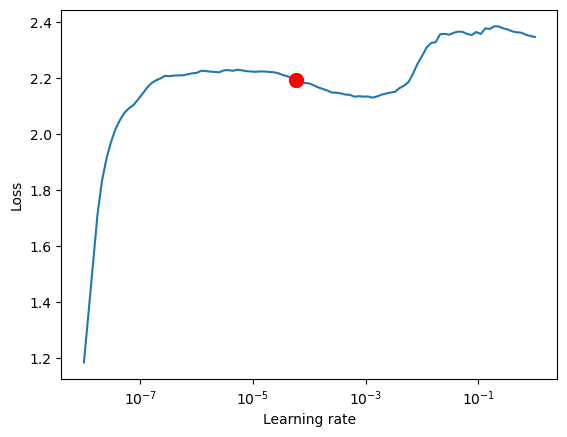

In [28]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr

In [29]:
# зададим новый Lr модели
new_lr = 5.7543993733715664e-05
new_lr

5.7543993733715664e-05

### Можем найти максимально возможный батч который влезет на нашу ГПУ

Не оптимальный размер батча для обучения, а именно максимально возможный на нашем оборудовании.

In [19]:
# model = LitModel((3, 224, 224), transfer=transfer_flag, learning_rate=new_lr)
# trainer = pl.Trainer(accelerator="gpu", auto_scale_batch_size="binsearch")

In [20]:
# call tune to find the batch size
# trainer.tune(model, dm)

### Непосредственно обучение модели

In [30]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# создадим обратный вызов на раннюю остановку обучения
early_stop_callback = EarlyStopping(monitor="val_loss", patience=10, verbose=False, mode="min")

# создадим обратный вызов на сохранение чекпоинта модели,
# по интересующей нас метрике
# saves top-K checkpoints based on "val_loss" metric
checkpoint_callback_val_loss = ModelCheckpoint(
    save_top_k=5,
    monitor="val_loss",
    mode="min",
    filename="check_point-{epoch:02d}-{val_loss:.2f}",
)

# saves last-K checkpoints based on "global_step" metric
# make sure you log it inside your LightningModule
checkpoint_callback_last_step = ModelCheckpoint(
    save_top_k=1,
    monitor="train_step",
    mode="max",
    filename="check_point-{epoch:02d}-{train_step}",
)


### Претрейн регрессора

In [31]:
# начинаем обучение модели

model = LitModel((3, 224, 224), emotion_num, transfer=True, learning_rate=0.1**3)

# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu", 
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step],
                     max_epochs=15,
                     log_every_n_steps=10)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(model, dm)

You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | neural_net | ResNet | 23.5 M
--------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.098    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [25]:
model = model.load_from_checkpoint("models_check/check_point-epoch=14-val_loss=2.05.ckpt")

### Тренеровка всей модели

In [26]:
# делаем обучаемой всю модель!
model.set_trainable()
model.learning_rate = 0.1**5

In [27]:
model.learning_rate

1.0000000000000003e-05

In [28]:
# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu", 
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step],
                     log_every_n_steps=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(model, dm)

/home/admin-gpu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/home/admin-gpu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/admin-gpu/Downloads/MADE_2022_contest_2/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 25.6 M
1 | regressor         | Linear | 1.0 K 
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.232   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/admin-gpu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [30]:
model = model.load_from_checkpoint("models_check/check_point-epoch=50-val_loss=1.06.ckpt")

Протестируем полученную модель

In [ ]:
# можем проверить на тестовой части (подсунув вместо теста val)
# trainer.test(model, dm.val_dataloader())

In [31]:
# можем проверить на val части датасета
trainer.validate(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1.0648345947265625
         val_mse            1.0648345947265625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.0648345947265625, 'val_mse': 1.0648345947265625}]

## Загрузим желаемый чекпоинт

In [32]:
# disable randomness, dropout, etc...
model.eval();

## Сделаем предсказание

### Сделаем предсказание на val

Проверим, что функции предсказания работаю корректно.
И что мы получаем тот же самый результат по метрике MSE, что и раньше.

In [33]:
# predict with the model
preds = trainer.predict(model, dm.test_by_val_dataloader())


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 14it [00:00, ?it/s]

In [34]:
y_preds = []
for sublist in preds:
    for item in sublist:
        y_preds.append(item[0])
        
y_preds = np.array(y_preds)

In [35]:
y_true = dm.val_target

In [36]:
# Введем метрики оценки качества модели
def mse(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()

def mae(y_true, y_pred):
    return (np.abs(y_true - y_pred)).mean()

In [37]:
# Оценим нашу модель на валидационной выборке:
print(f"MSE = {mse(y_true, y_preds)}")
print(f"MAE = {mae(y_true, y_preds)}")

MSE = 1.064834620515355
MAE = 0.7869153105964263


### Сделаем предсказание непосредственно на тесте

In [38]:
# predict with the model
preds = trainer.predict(model, dm.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 14it [00:00, ?it/s]

In [39]:
y_preds = []
for sublist in preds:
    for item in sublist:
        y_preds.append(item[0])
        
y_preds = np.array(y_preds)

In [40]:
y_preds

array([ 7.32678032, 11.18929768,  1.44223154, ..., 11.48866272,
        6.14334536,  2.86557984])

# публикуем сабмит

In [41]:
submission = pd.read_csv('data/sample_submission.csv')

In [42]:
submission

,label
0,0
1,0
2,0
3,0
4,0
...,...
5995,0
5996,0
5997,0
5998,0


In [43]:
submission['label'] = y_preds


In [44]:
submission

,label
0,7.326780
1,11.189298
2,1.442232
3,6.111101
4,8.025280
...,...
5995,12.518585
5996,9.975379
5997,11.488663
5998,6.143345


In [45]:
submission_path = 'submission/PyTorchLighnting_Resnet50.csv'

In [46]:
submission.to_csv(submission_path, index=False)

## Conclusion

I will encourage you to play with the code and train an image classifier with a dataset of your choice from scratch and using transfer learning. 


To learn more about transfer learning check out these resources:
- [Gotchas of transfer learning for image classification](https://docs.google.com/presentation/d/1s29WOQoQvBD5KoPUzE5TPcavjqno8ZgnZaSljHGGHVU/edit?usp=sharing) by Sayak Paul.
- [Transfer Learning with Keras and Deep Learning by PyImageSearch.](https://www.pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/)
- [Transfer Learning - Machine Learning's Next Frontier](https://ruder.io/transfer-learning/) by Sebastian Ruder.





